In [3]:
import random
import pandas as pd
import pylab as pl
import numpy as np
import scipy.spatial as ss
import sklearn.cluster as sc
import sklearn.manifold as sm
import sklearn.datasets as ds
import sklearn.metrics as smt
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from sklearn.base import BaseEstimator, ClusterMixin
from sklearn.cluster import DBSCAN
import matplotlib.pyplot as plt

%matplotlib inline

plt.rcParams['figure.figsize'] = (12, 8)


In [6]:
class Clustering(BaseEstimator, ClusterMixin):
    """
    Implement DBSCAN clustering algorithm.
    """

    NOISE_LABEL = -1
    UNDEFINED_CLUSTER_LABEL = 0

    def __init__(self, eps=0.5, min_samples=5):
        self._eps = eps
        self._min_samples = 5

    def fit(self, X, y=None):
        self._X = X
        self._compute_neighbors(X)
        self._dbscan(X)
        return self

    def predict(self, X):
        fit_X_list = self._X.tolist()
        sub_indexes = [fit_X_list.index(x) for x in X]
        sub_labels = [self._labels[i] for i in sub_indexes]
        return np.ndarray(sub_labels)

    def fit_predict(self, X, y=None):
        self.fit(X, y)
        return self._labels

    def _compute_neighbors(self, X):
        neighbors_model = NearestNeighbors(radius=self._eps)
        neighbors_model.fit(X)
        self.neighborhoods = neighbors_model.radius_neighbors(X, self._eps,
                                                              return_distance=False)

    def _dbscan(self, X):
        current_cluster = self.UNDEFINED_CLUSTER_LABEL
        self._labels = np.zeros(X.shape[0])
        visited_samples = np.zeros(X.shape[0], dtype=np.bool)

        # Iterates all points.
        for i in range(X.shape[0]):

            # Skips already processed points.
            if visited_samples[i]:
                continue
            else:
                visited_samples[i] = True

            # Searches neighbors.
            neighbors = self.neighborhoods[i].tolist()

            # Checks is it a noise.
            is_low_density = (len(neighbors) < self._min_samples)
            if is_low_density:
                self._labels[i] = self.NOISE_LABEL
                continue

            # Searches reachable points for new cluster starting from current core point.
            current_cluster = current_cluster + 1
            self._labels[i] = current_cluster
            candidates = set(neighbors)
            candidates.remove(i)
            while len(candidates) > 0:
                j = candidates.pop()
                if not visited_samples[j]:
                    visited_samples[j] = True

                    neighbors = self.neighborhoods[j].tolist()
                    is_high_density = (len(neighbors) >= self._min_samples)
                    if is_high_density:
                        candidates = candidates.union(neighbors)

                is_point_in_cluster = (self._labels[j] > self.UNDEFINED_CLUSTER_LABEL)
                if not is_point_in_cluster:
                    self._labels[j] = current_cluster

In [12]:
# Test own DBSCAN algorithm on simple generated dataset.
n_samples = 1500
X, y = datasets.make_blobs(n_samples=n_samples, random_state=8)
X = StandardScaler().fit_transform(X)
eps = 0.3
min_samples = 10

predicted = Clustering(eps=eps, min_samples=min_samples).fit_predict(X)
assert smt.adjusted_rand_score(y, predicted) == 1

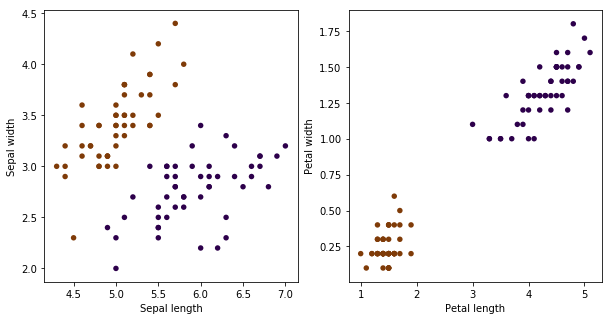

In [4]:
iris = ds.load_iris()
x_iris = iris.data[:100]
y_iris = iris.target[:100]

pl.figure(figsize=(10, 5))

pl.subplot(1, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Sepal length')
plt.ylabel('Sepal width')

pl.subplot(1, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
plt.xlabel('Petal length')
plt.ylabel('Petal width')
pl.show()

In [7]:
pred_iris = Clustering().fit_predict(x_iris)
print("Adjusted Rand index for iris is: %.2f" % smt.adjusted_rand_score(y_iris, pred_iris))

Adjusted Rand index for iris is: 0.87


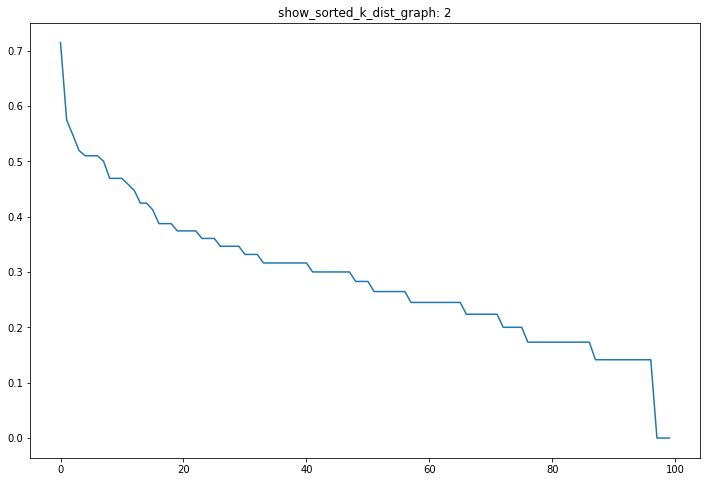

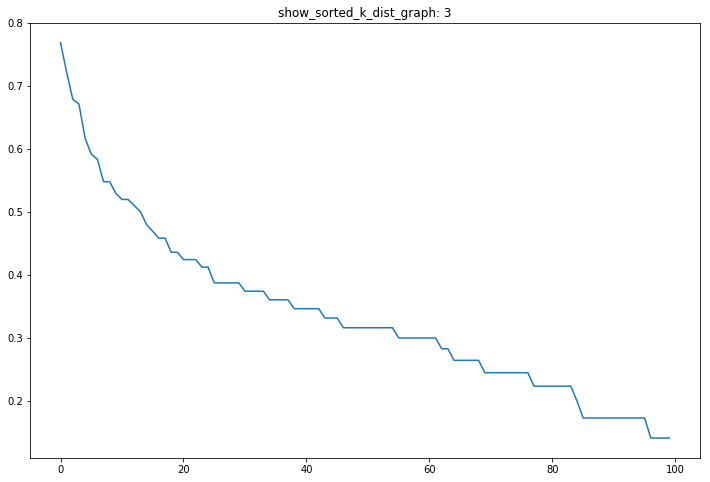

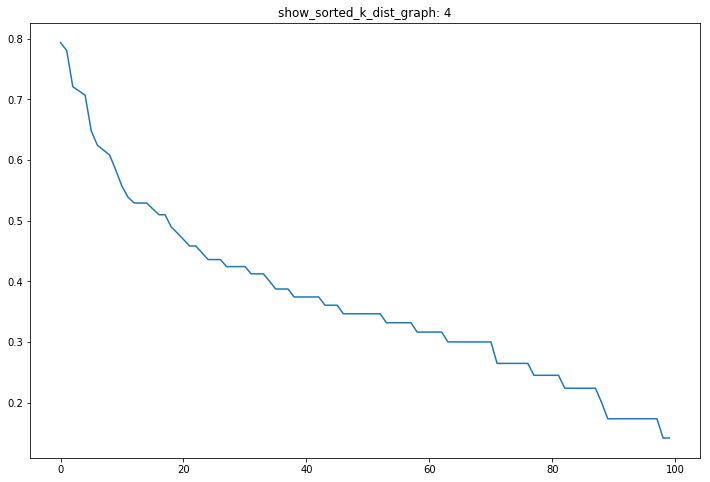

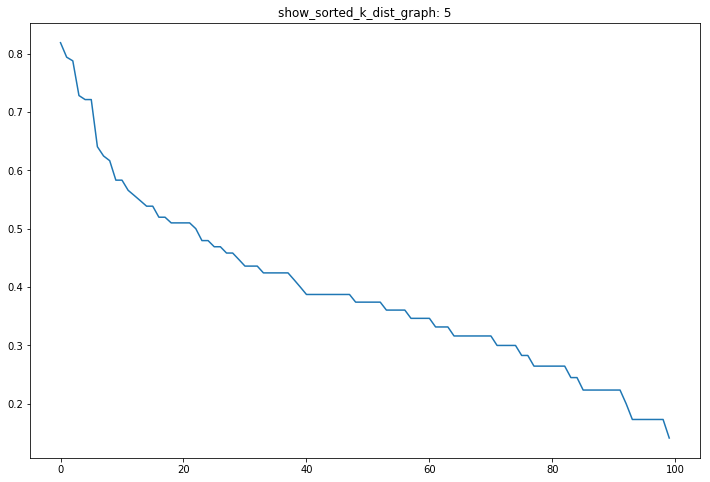

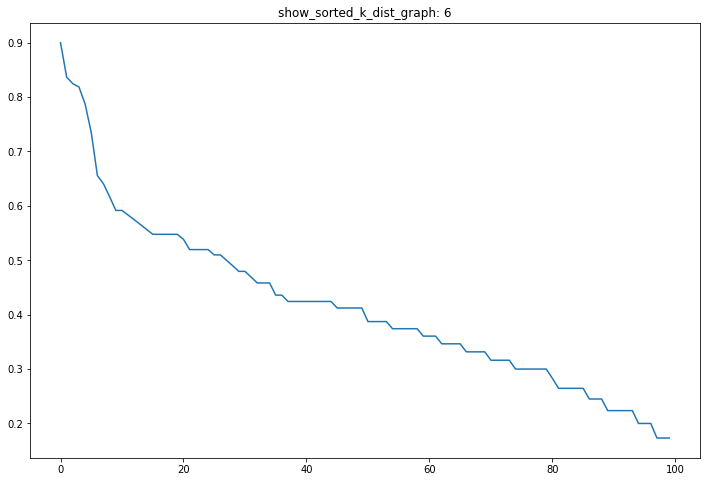

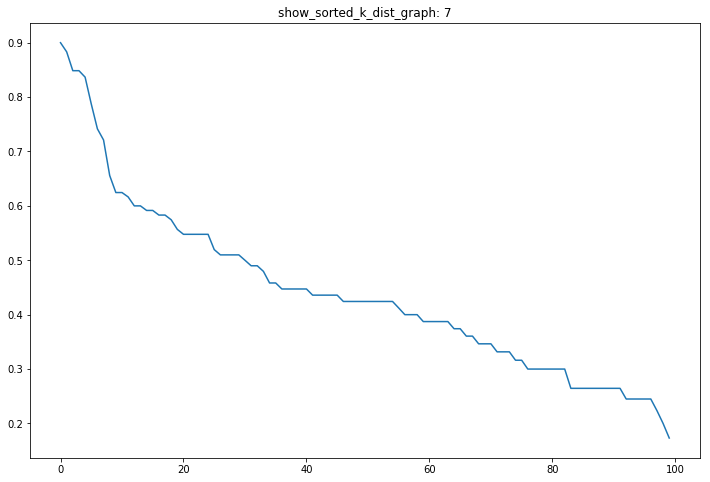

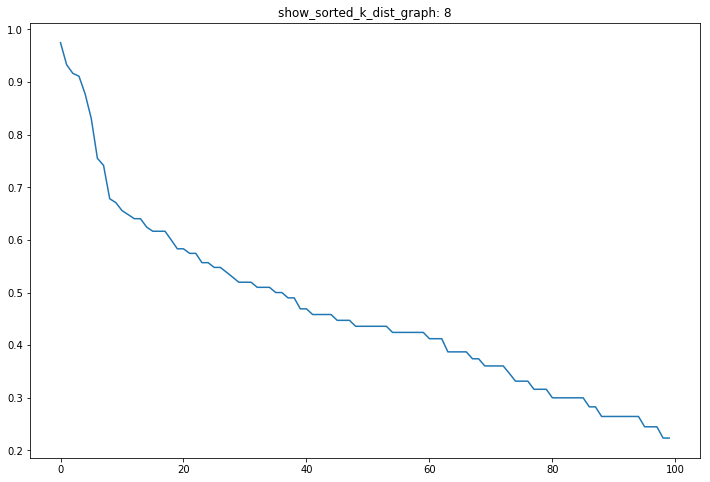

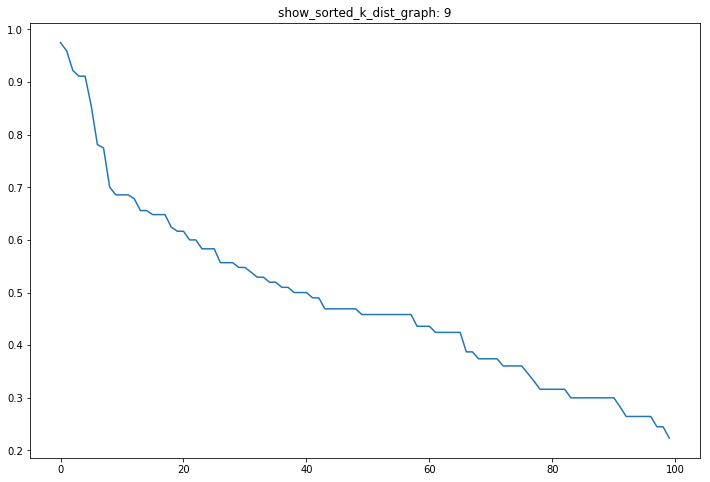

In [14]:
# ARI with default random parameters is just 0.87, when ideal is 1. Lets try to enhance this score.
# Searches parameters by evaluating sorted k-dist graph according to method described in DBSCAN original article.
def show_sorted_k_dist_graph(X, k):
    neighbors_model = NearestNeighbors(n_neighbors=k)
    neighbors_model.fit(X)
    distances, neighborhoods = neighbors_model.radius_neighbors()
    k_distances = [sorted(neighborhood)[k - 1] if len(neighborhood) >= k else np.max(neighborhood) for neighborhood in distances]
    k_distances = sorted(k_distances, reverse=True)

    plt.plot(k_distances)
    plt.title("show_sorted_k_dist_graph: {}".format(k))
    plt.show()
    
# Evaluates graphs for different k and constructs parameters set for future evaluation.
for k in range(2, 10):
    show_sorted_k_dist_graph(x_iris, k)
    

In [15]:
parameters = [
    (2, 0.5),
    (3, 0.55),
    (4, 0.52),
    (5, 0.59),
    (6, 0.59),
    (7, 0.62),
    (8, 0.68),
    (9, 0.69),
]

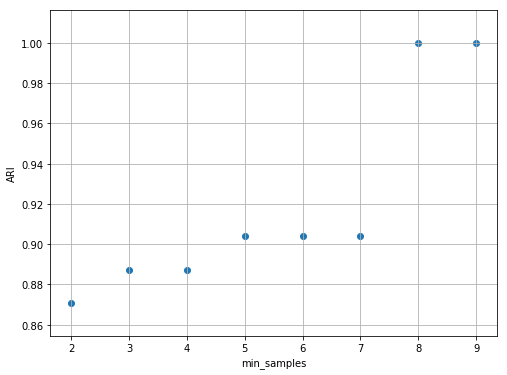

In [20]:
# Calculates ARI for gathered parameters.
scores = []
min_samples_param = []

def quality(X, y, eps, min_samples):
    predicted = Clustering(eps=eps, min_samples=min_samples).fit_predict(X)
    score = smt.adjusted_rand_score(y, predicted)
    return score

for i, (k, eps) in enumerate(parameters):
    score = quality(x_iris, y_iris, eps, k)
    scores.append(score)
    min_samples_param.append(k)
    
pl.figure(figsize=(8, 6))
pl.scatter(min_samples_param, scores)
pl.ylabel("ARI")
pl.xlabel("min_samples")
pl.grid()
pl.show()

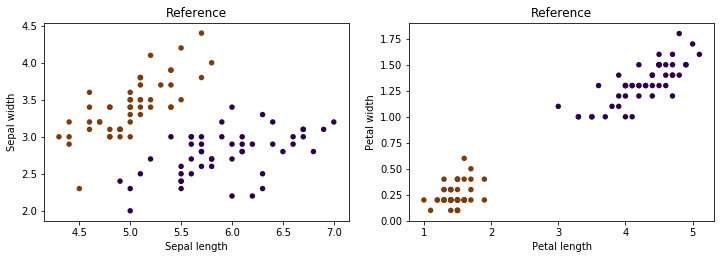

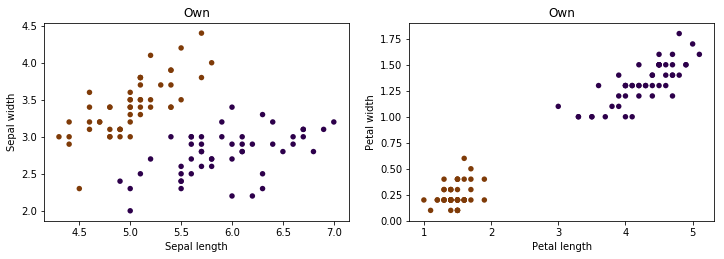

In [25]:
# Above plot shows that best params according ARI are (8, 0.68) and (9, 0.69), lets show clusters with these params.
predicted = Clustering(eps=0.68, min_samples=8).fit_predict(x_iris)

pl.subplot(2, 2, 1)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
pl.xlabel('Sepal length')
pl.ylabel('Sepal width')
pl.title('Reference')

pl.subplot(2, 2, 2)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=y_iris, cmap=pl.cm.PuOr, lw=0, s=30)
pl.xlabel('Petal length')
pl.ylabel('Petal width')
pl.title('Reference')
pl.show()

pl.subplot(2, 2, 3)
pl.scatter(x_iris[:, 0], x_iris[:, 1], c=predicted, cmap=pl.cm.PuOr, lw=0, s=30)
pl.xlabel('Sepal length')
pl.ylabel('Sepal width')
pl.title('Own')

pl.subplot(2, 2, 4)
pl.scatter(x_iris[:, 2], x_iris[:, 3], c=predicted, cmap=pl.cm.PuOr, lw=0, s=30)
pl.xlabel('Petal length')
pl.ylabel('Petal width')
pl.title('Own')
pl.show()

In [ ]:
# All graphs are actually equal, as they should be according to ARI == 1. 
# Possibly it is due to small dataset and luck.
# But because our goal now is to search best parameters, not analyzing full dataset, so we can treat we found them!

1.0
1.0
1.0
1.0


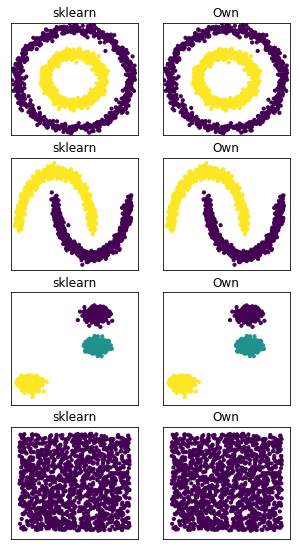

In [32]:
# Lets compare our algorithm implementation with sklearn's on popular autogenerated datasets.
np.random.seed(0)

n_samples = 1500
noisy_circles = datasets.make_circles(n_samples=n_samples, factor=.5,
                                      noise=.05)
noisy_moons = datasets.make_moons(n_samples=n_samples, noise=.05)
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
no_structure = np.random.rand(n_samples, 2), None

pl.figure(figsize=(2 + 3, 9.5))

eps=0.3
min_samples=5

data = [noisy_circles, noisy_moons, blobs, no_structure]
for i_dataset, dataset in enumerate(data):
    X, y = dataset
    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    y_sklearn = DBSCAN(eps=eps, min_samples=min_samples).fit_predict(X)
    y_own = Clustering(eps=eps, min_samples=min_samples).fit_predict(X)
    
    # plot
    pl.subplot(4, 2, i_dataset * 2 + 1)
    pl.scatter(X[:, 0], X[:, 1], c=y_sklearn, s=10)
    pl.xlim(-2, 2)
    pl.ylim(-2, 2)
    pl.xticks(())
    pl.yticks(())
    pl.title('sklearn')
    
    pl.subplot(4, 2, i_dataset * 2 + 2)
    pl.scatter(X[:, 0], X[:, 1], c=y_own, s=10)
    pl.xlim(-2, 2)
    pl.ylim(-2, 2)
    pl.xticks(())
    pl.yticks(())
    pl.title('Own')
    
    score = smt.adjusted_rand_score(y_sklearn, y_own)
    print(score)

pl.show()

In [ ]:
# By visual graphs estimation and ARI scores accuracy of our DBSCAN implementation is like as sklearn's at least on these datasets.